In [1]:
import sys
sys.path.append('..')
import umbrella_mesh
import linkage_vis
import load_jsondata
from configuration import *
from visualization_helper import *

In [2]:
import numpy as np

In [3]:
sys.path.append('../UmbrellaGen')
import grid_gen

### Define the grid dimensions and Umbrella Valence you want

In [4]:
# please make sure rows anx cols are >=2
rows = 10
cols = 5 # is doubled (one col is two element : /\\/ )

In [5]:
degree = 3 # TriUmbrellas
numUmbrellas = (rows * 2) * cols

### Define your favorite height, material and cross-section function! Umbrellas are sequenced row-wise if you use the grid

In [6]:
def myHeightFunc(numUmbrellas): 
    heights = [1] * numUmbrellas # Scale Factor of heights. Set minHeight to your desired minimum absolute height.
    for uid in range(numUmbrellas):
        # heights[uid] += (0.1 * uid**1.6 + 0.1 *(numUmbrellas - 1 - uid)**1.6)
        heights[uid] += (0.01 * uid**2 + 0.01 *(numUmbrellas - 1 - uid)**2)
    heights = [h/min(heights) for h in heights]
    return heights

In [7]:
print(f"There is {numUmbrellas} cells with respective heights: {myHeightFunc(numUmbrellas)}")

There is 100 cells with respective heights: [1.9798040391921614, 1.9406118776244752, 1.9022195560887822, 1.8646270745850828, 1.8278344331133771, 1.7918416316736652, 1.7566486702659465, 1.7222555488902216, 1.6886622675464906, 1.655868826234753, 1.623875224955009, 1.5926814637072582, 1.5622875424915015, 1.5326934613077383, 1.5038992201559684, 1.4759048190361927, 1.4487102579484101, 1.4223155368926212, 1.3967206558688259, 1.3719256148770245, 1.3479304139172164, 1.324735052989402, 1.302339532093581, 1.2807438512297538, 1.2599480103979201, 1.2399520095980803, 1.2207558488302337, 1.202359528094381, 1.1847630473905217, 1.1679664067186561, 1.151969606078784, 1.1367726454709057, 1.122375524895021, 1.1087782443511298, 1.095980803839232, 1.083983203359328, 1.0727854429114176, 1.0623875224955006, 1.0527894421115775, 1.043991201759648, 1.035992801439712, 1.0287942411517697, 1.0223955208958209, 1.0167966406718656, 1.0119976004799038, 1.0079984003199358, 1.0047990401919615, 1.0023995200959805, 1.0007

### Compute Geometry with Regular Grid

In [8]:
# The height function is a scaling function relative to the minHeight
minHeight = 64
# grid_gen.genUmbrellaWithHeights(degree, rows, cols, height_scales = myHeightFunc(numUmbrellas),minHeight = minHeight)

### Compute Geometry with Custom Equilateral Tiling with triangle

In [9]:
import mesh
base_mesh = mesh.Mesh("../../data/plane_equi.obj")
V, F = base_mesh.vertices(), base_mesh.elements()
V_3d = np.zeros((len(V), 3))
V_3d[:, :2] = V
edge_length = np.linalg.norm(V_3d[F][0, 0] - V_3d[F][0, 1])
numUmbrellas = len(F)
grid_gen.genUmbrellaWithHeights(degree, rows, cols, height_scales = myHeightFunc(numUmbrellas),minHeight = minHeight, base_mesh = (V_3d.tolist(),F.tolist()), edge_length=edge_length)

### Initialization of Umbrella Class

In [10]:
name = 'grid_dump'
input_path = '../UmbrellaGen/{}.json.gz'.format(name)
io, input_data, target_mesh, curr_um, plate_thickness_scaled, target_height_multiplier = parse_input(input_path, handleBoundary = False, isHex = (degree == 6), use_target_surface = False)
# Can set use_target_surface = True to add target_mesh to the curr_um class for target attraction during deployment as well as inverse design

In [11]:
nb_cell = curr_um.numUmbrellas()
center_position = np.zeros([nb_cell, 3])
for i in range(nb_cell):
    top_idx = curr_um.getUmbrellaCenterJi(i, 0)
    center_position[i] = curr_um.joint(top_idx).position

# [RQ] what about others second param's values (1 is for bottom, but what about 2,3,4)
# for i in range(10000):
#     print(curr_um.getUmbrellaCenterJi(0, i))

vertices = input_data['base_mesh_v']
edge = np.roll(np.insert(input_data['base_mesh_f'], 0, input_data['base_mesh_f'][:,0], axis=1), -1, axis=1)

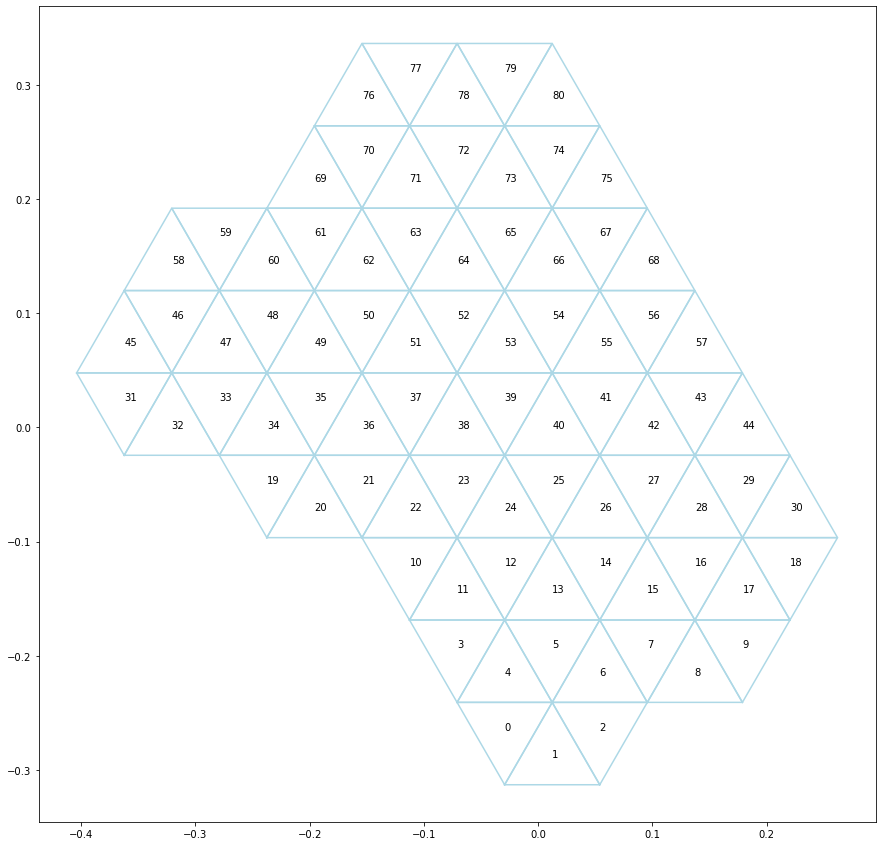

In [12]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(15, 15))
# plt.scatter(center_position[:, 0], center_position[:, 1], s=5, color='blue')
for i, ([x,y,z], h) in enumerate(zip(center_position, curr_um.umbrellaHeights)):
    # plt.annotate(f'{f"{i}".center(10)}\n[{h:.2f}]', (x,y), xytext=(-15,-10), textcoords='offset points', color='black') # also plot the height
    plt.annotate(f'{i}', (x,y), xytext=(0,0), textcoords='offset points', color='black')
for e in vertices[edge]:
    plt.plot(e[:, 0], e[:, 1], color="lightblue")
plt.axis('equal')
plt.show()

In [13]:
rod_colors = get_color_field(curr_um, input_data, uidBased = False) 
lview = linkage_vis.LinkageViewer(curr_um, width=800, height=600)
lview.update(scalarField = rod_colors)
lview.show()

Renderer(camera=PerspectiveCamera(aspect=1.3333333333333333, children=(PointLight(color='#999999', position=(0…

### Deploy umbrellaMesh - Go through configuration.py to get some idea about deployment hyper-params. It's okay if you do not understand everything there

In [14]:
print(f"\
PLATE CHARACTERISTIQUES:\n\
\tplate thickness   : {input_data['thickness']}\n\
\tplate edge length : {input_data['plate_edge_length']}")

PLATE CHARACTERISTIQUES:
	plate thickness is 0.00832632927026812
	plate edge length is 0.08326329271822491


In [15]:
# print(*input_data.keys(), sep='\n')

In [16]:
# === deploymentEnergyWeight ===
# in `staged_deployment()`
# 0 : not activated
# 1 : activated'
# --> if not activated, height is not arbitrary


unactivated_cell = [37,39,40,41, 51,52,54,55, 64,65,66]
# unactivated_cell = [i for i in range(curr_um.numUmbrellas())]


# =====
weights_per_cell = np.ones(curr_um.numUmbrellas())
weights_per_cell[unactivated_cell] = 0
dep_factors = np.logspace(-4, 0, 5)
dep_weights = np.einsum('i, j -> ij', dep_factors, weights_per_cell)

In [17]:
# === targetDeploymentHeightVector ===
# in `configure_umbrella_pre_deployment()`
# 0 means superpoition of plate | [RQ] should we consider this value for unactivated plate ??
# 1 means plate are in contact (== default value ==)
# higher value are plate's thickness multiple


# list of slice (cell index, target_height_multiple)
target_height = [(0,10),(1,10),(2,10),(53,15)]


# =====
target_height_multiplier = np.ones(curr_um.numUmbrellas())
for idx,h in target_height:
    target_height_multiplier[idx] = h

if (((target_height_multiplier-1) * plate_thickness_scaled)[unactivated_cell] == np.zeros(len(unactivated_cell))).any():
    print(f"unactivated cells ({' '.join(map(str, unactivated_cell))}) have target height, which will be violated")

unactivated cells (37 37 39 40 41 51 52 54 55 64 65 66) have target height, which will be violated


In [18]:
success, eqays = deploy_umbrella_pin_rigid_motion(curr_um,
                                                  plate_thickness_scaled,
                                                  target_height_multiplier,
                                                  lview, 
                                                  rod_colors,
                                                  analysis = True,
                                                  dep_weights=dep_weights)
"is success
# line 109 : why +6 in fixedVars
# line 121 : why if(i%1==0) ? : always true

True

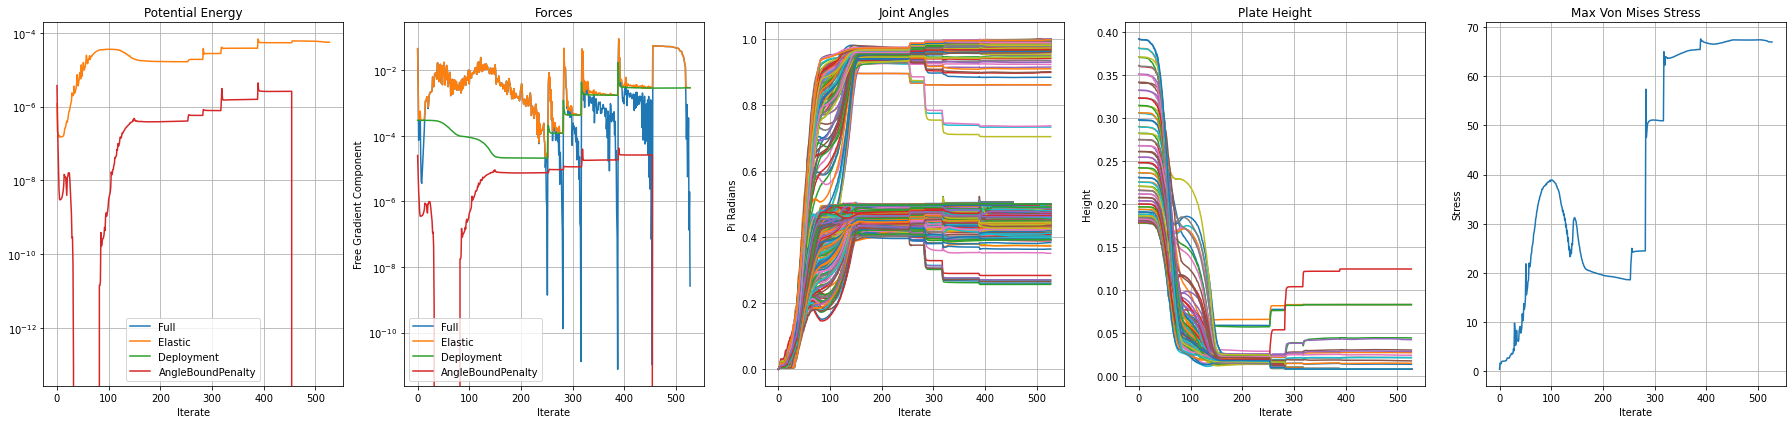

In [19]:
eqays.plot()
# [RK] any units ?

## Stress Visualization

In [20]:
sview = linkage_vis.LinkageViewer(curr_um, width=800, height=600)
sview.update(scalarField = curr_um.maxVonMisesStresses())
# sview.update(scalarField = curr_um.maxBendingStresses())
# sview.update(scalarField = curr_um.twistingStresses())
sview.show()

Renderer(camera=PerspectiveCamera(aspect=1.3333333333333333, children=(PointLight(color='#999999', position=(0…

In [21]:
sigma_vm = np.array(curr_um.maxVonMisesStresses())
sigma_vm.max(), sigma_vm.min()

(72.70259755164099, 3.1086244689504383e-12)

In [22]:
sigma_bending = np.array(curr_um.maxBendingStresses())
sigma_bending.max(), sigma_bending.min()

(71.58974304632223, 0.0)